In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

### Doc anh template va anh goc

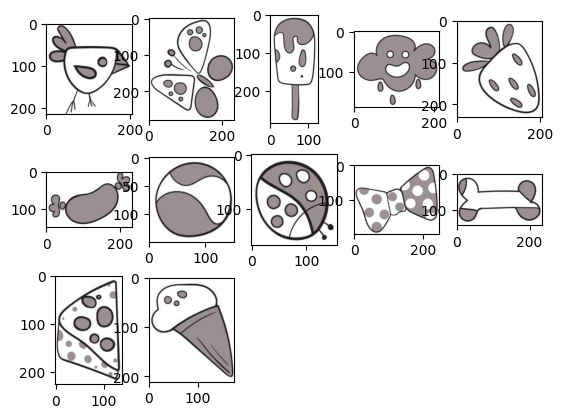

In [ ]:
def read_image(folder_path):
  template = []
  for file in os.listdir(folder_path):
    img_bgr = cv2.imread(os.path.join(folder_path, file))
    template.append(img_bgr[:,:,::-1])
  return template
templates = read_image("/home/hungmanh/projects/multi/finding/object 2")


for idx in range(len(templates)):
    plt.subplot(3, 5, idx + 1)
    plt.imshow(templates[idx])


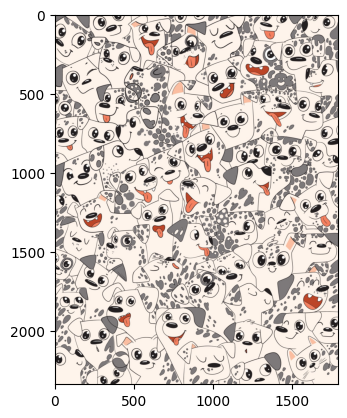

In [90]:
image = cv2.imread("/home/hungmanh/projects/multi/finding/data/cut_2.png")
plt.imshow(image[:,:,::-1])
plt.show()

### Cach 1 : SIFT

In [ ]:
output_image = image[:,:,::-1].copy()
output_templates = templates.copy()

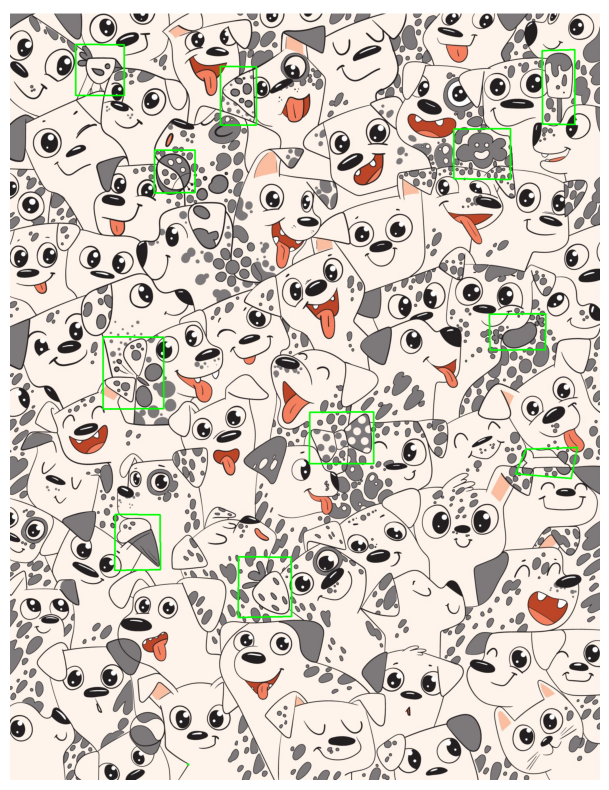

In [ ]:
image_gray = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)

for idx in range(len(output_templates)):
    template_gray = cv2.cvtColor(output_templates[idx], cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(template_gray, None)
    kp2, des2 = sift.detectAndCompute(image_gray, None)

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]

    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        h, w = template_gray.shape
        pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        image_boxed = cv2.polylines(output_image, [np.int32(dst)], True, (0, 255, 0), 3)
        
plt.figure(figsize=(15,10))
plt.imshow(image_boxed[:,:,::-1])
plt.axis('off')
plt.show()


### Cach 2 : Multi scale template matching

In [87]:
output_image = image[:,:,::-1].copy()
output_templates = templates.copy()

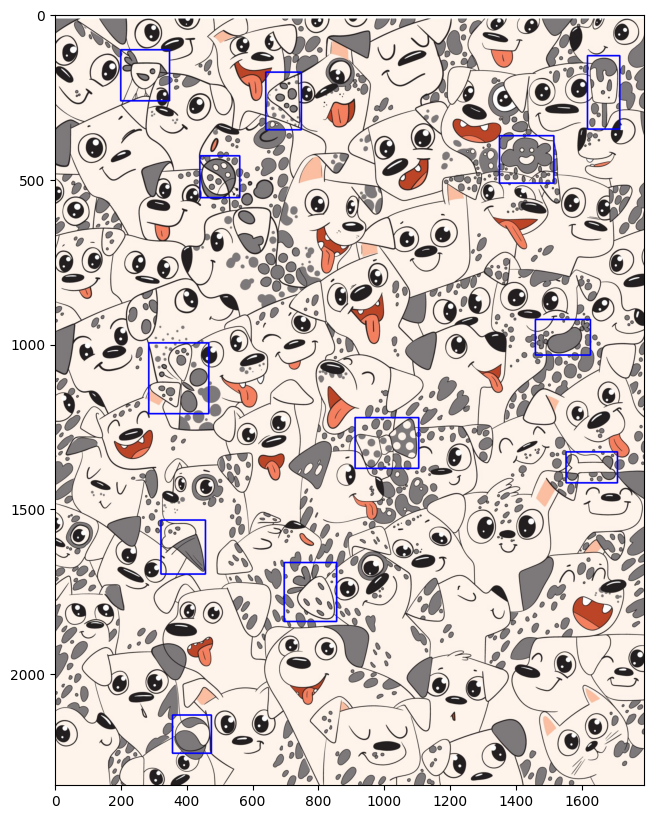

In [ ]:
import imutils
scales = np.linspace(0.5, 1, 10)

(tH, tW) = output_image.shape[:2] 

for idx in range(len(templates)):
    output_template = output_templates[idx]
    best_match = None
    max_val = -1  
    best_loc = None
    best_scale = None
    best_w, best_h = None, None
    for scale in scales:
        resized = imutils.resize(output_template, width=int(output_template.shape[1] * scale))        
        w, h = resized.shape[1], resized.shape[0]  

        if h > tH or w > tW:
            break

        result = cv2.matchTemplate(output_image, resized, cv2.TM_CCOEFF_NORMED)
        (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

        if maxVal > max_val:
            best_match = maxLoc
            max_val = maxVal
            best_loc = maxLoc
            best_scale = scale
            best_w, best_h = w, h

    if best_loc is not None:
        top_left = best_loc
        bottom_right = (top_left[0] + best_w, top_left[1] + best_h)
        cv2.rectangle(output_image, top_left, bottom_right, (0, 0, 255), 3)

plt.figure(figsize=(10,10))        
plt.imshow(output_image)
plt.show()

